# Import data

In [2]:
# Download data from Google Drive

import gdown 

url = 'https://drive.google.com/uc?id=1CxOcvyFlx2V-8ubpRuVZclOBUYFPe_t6'
output = 'MLTollsStackOverflow.csv'
gdown.download(url, output)                                                                  

Downloading...
From: https://drive.google.com/uc?id=1CxOcvyFlx2V-8ubpRuVZclOBUYFPe_t6
To: /home/user/Data-science/time_series/kats_examples/MLTollsStackOverflow.csv
100%|██████████| 30.5k/30.5k [00:00<00:00, 14.1MB/s]


'MLTollsStackOverflow.csv'

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("MLTollsStackOverflow.csv")

In [5]:
df["month"] = pd.to_datetime(df["month"], format="%y-%b")
df = df.set_index("month")

In [6]:
python = df["python"].to_frame()

In [7]:
train_len = 102
train = python.iloc[:train_len]
test = python.iloc[train_len:]

# Turn Data into Time Series

In [8]:
from kats.consts import TimeSeriesData

In [9]:
ts = TimeSeriesData(train.reset_index(), time_col_name="month")

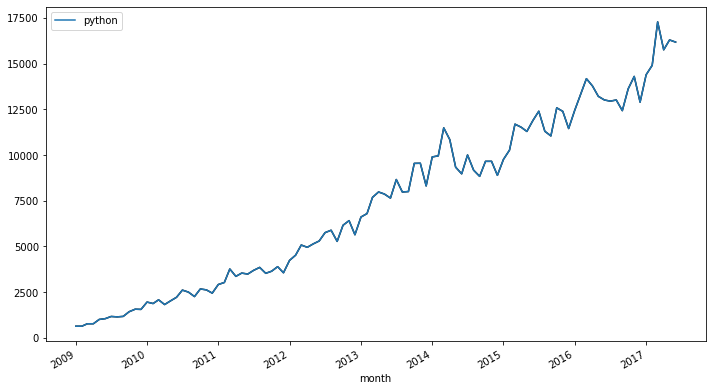

In [10]:
ts.plot(cols=["python"])

# Forecasting

## Facebook Prophet

In [11]:
from kats.models.prophet import ProphetModel, ProphetParams

params = ProphetParams(seasonality_mode="multiplicative")
m = ProphetModel(ts, params)

In [12]:
m.fit()

In [13]:
fcst = m.predict(steps=30, freq="MS")

In [14]:
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,2017-07-01,15723.041210,15209.994766,16251.627974
1,2017-08-01,15052.424297,14547.116677,15542.539639
2,2017-09-01,14358.842111,13815.231540,14861.490816
3,2017-10-01,15997.133144,15475.522236,16519.415347
4,2017-11-01,16249.837587,15707.651669,16808.657055


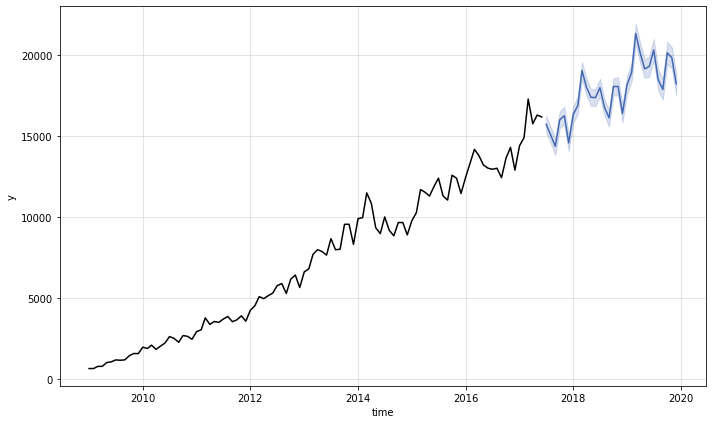

In [15]:
m.plot()

In [16]:
import matplotlib.pyplot as plt

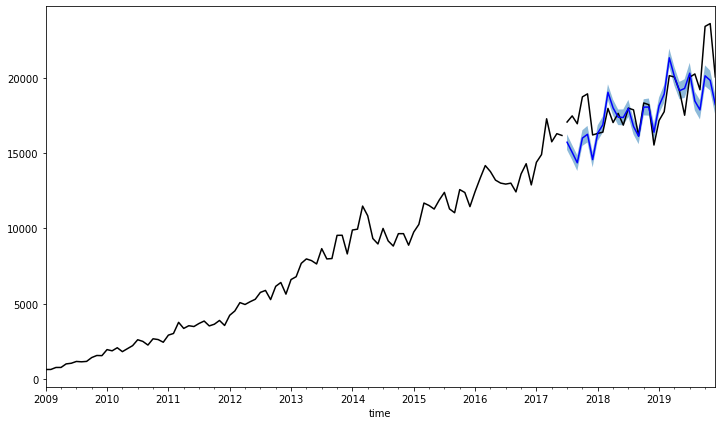

In [17]:
fig, ax = plt.subplots(figsize=(12, 7))
train.plot(ax=ax, label="train", color="black")
test.plot(ax=ax, color="black")
fcst.plot(x="time", y="fcst", ax=ax, color="blue")
ax.fill_between(test.index, fcst["fcst_lower"], fcst["fcst_upper"], alpha=0.5)
ax.get_legend().remove()

## Holt-Winters

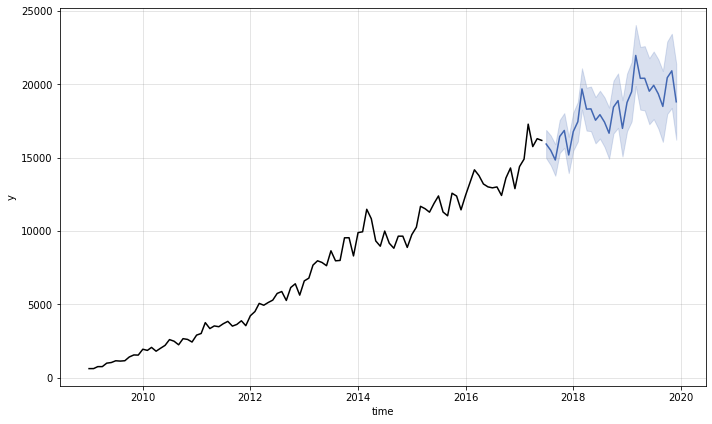

In [18]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
import warnings
warnings.simplefilter(action='ignore')

params = HoltWintersParams(
            trend="add",
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()


# Detect change point

In [19]:
from IPython.core.pylabtools import figsize

In [20]:
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector
import matplotlib.pyplot as plt

In [22]:
figsize(15, 7)

The change point is on 2013-02-01 00:00:00


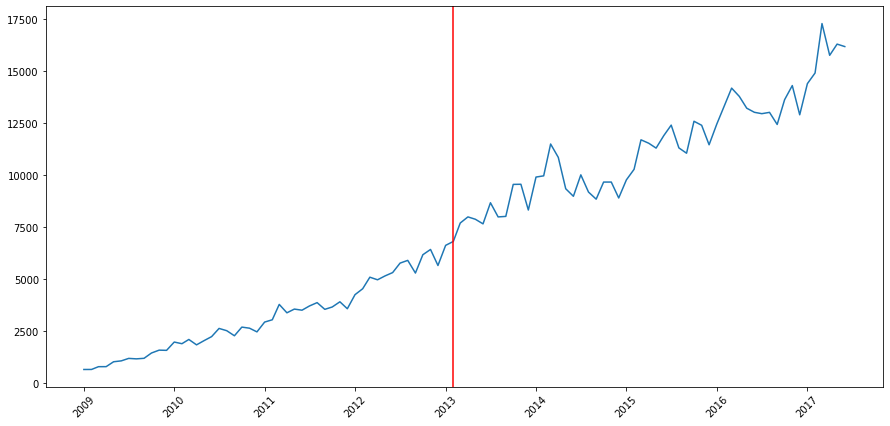

In [35]:
detector = CUSUMDetector(ts)

change_points = detector.detector(change_directions=["increase", "decrease"])

for change_point in change_points:
    print("The change point is on", change_point[0].start_time)

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

In [36]:
def get_ts(topic: str):
    return TimeSeriesData(df[topic].to_frame().reset_index(), time_col_name="month")

In [37]:
def detect_change_point(topic: str):
    ts = get_ts(topic)
    detector = CUSUMDetector(ts)

    change_points = detector.detector()
    for change_point in change_points:
        print("The change point is on", change_point[0].start_time)

    # plot the results
    plt.xticks(rotation=45)
    detector.plot(change_points)
    plt.show()

The change point is on 2015-12-01 00:00:00


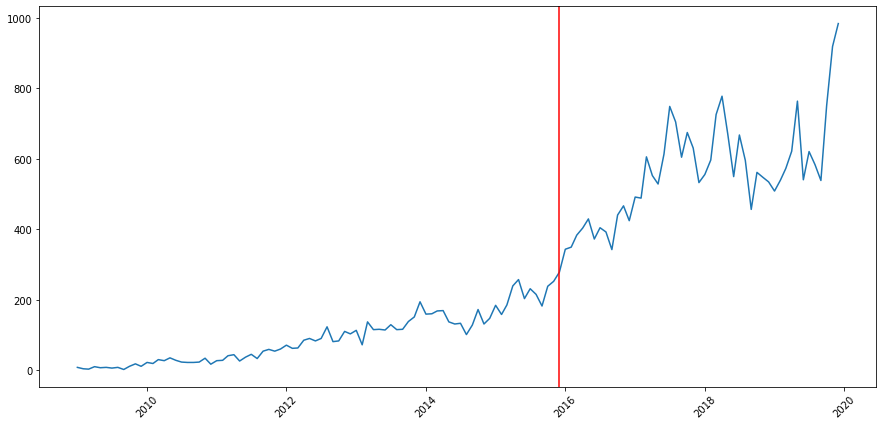

In [38]:
detect_change_point("machine-learning")

The change point is on 2015-11-01 00:00:00


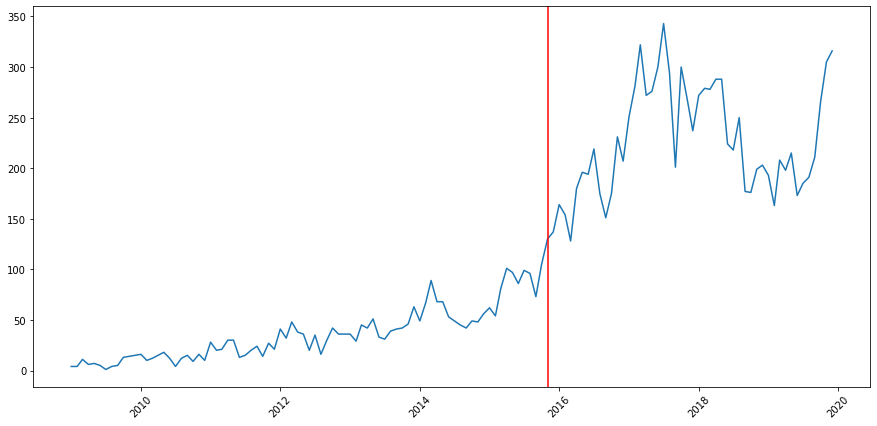

In [39]:
detect_change_point("neural-network")

The change point is on 2016-09-01 00:00:00


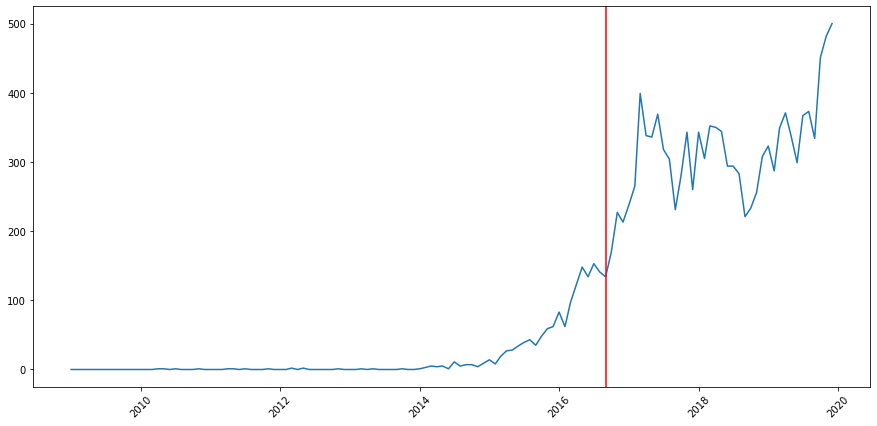

In [40]:
detect_change_point("deep-learning")

The change point is on 2015-07-01 00:00:00


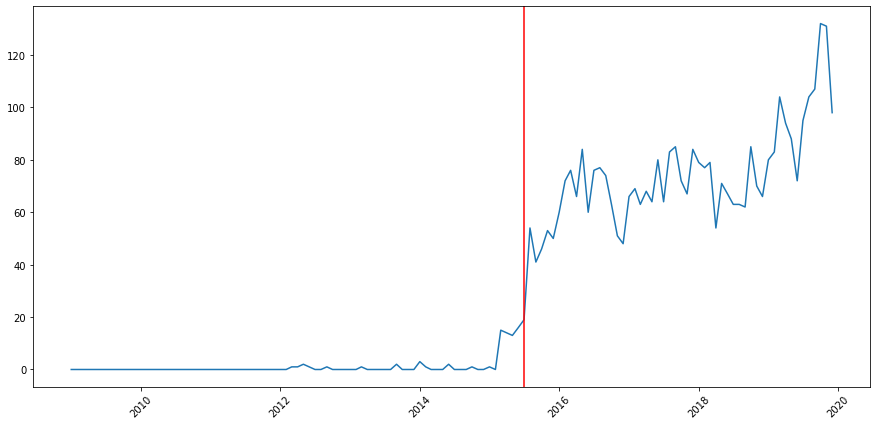

In [41]:
detect_change_point("jupyter")

The change point is on 2016-02-01 00:00:00


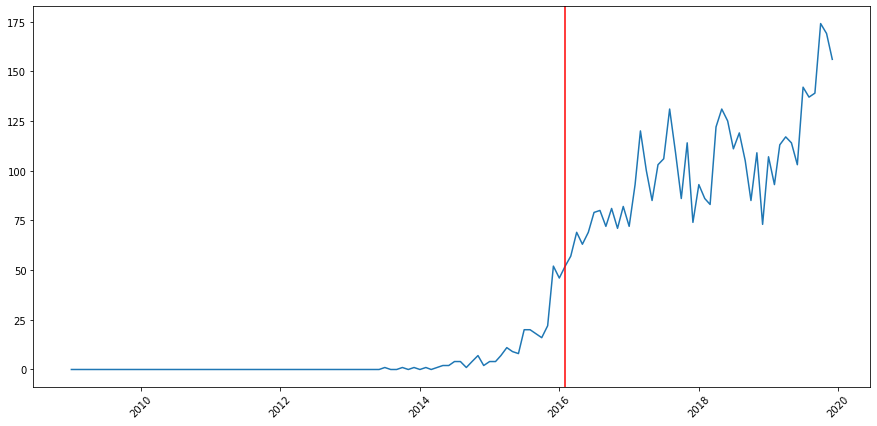

In [42]:
detect_change_point("plotly")

The change point is on 2017-02-01 00:00:00


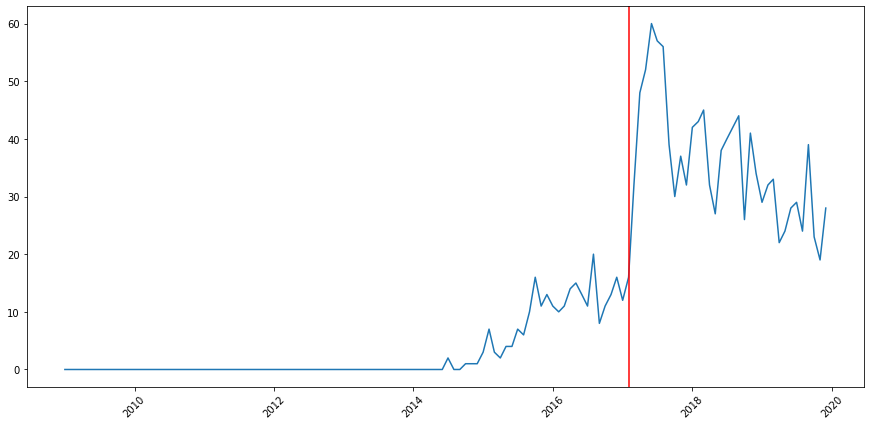

In [43]:
detect_change_point("H2o")

The change point is on 2016-12-01 00:00:00


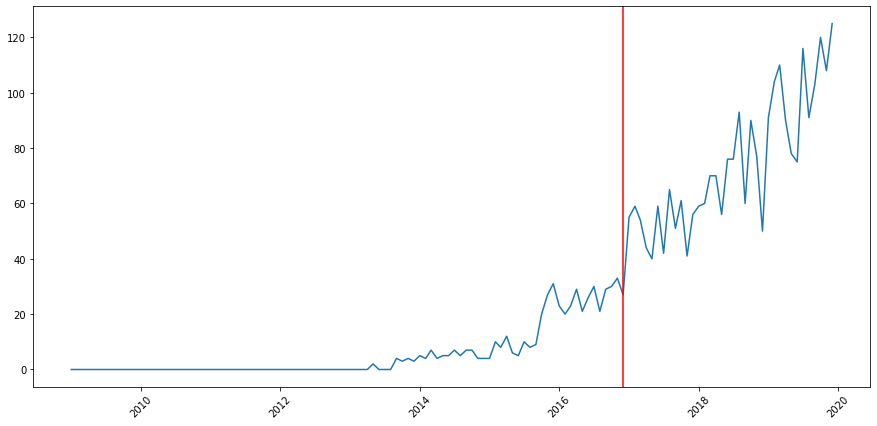

In [44]:
detect_change_point("Colab")

# Outlier Detection

<AxesSubplot:xlabel='month'>

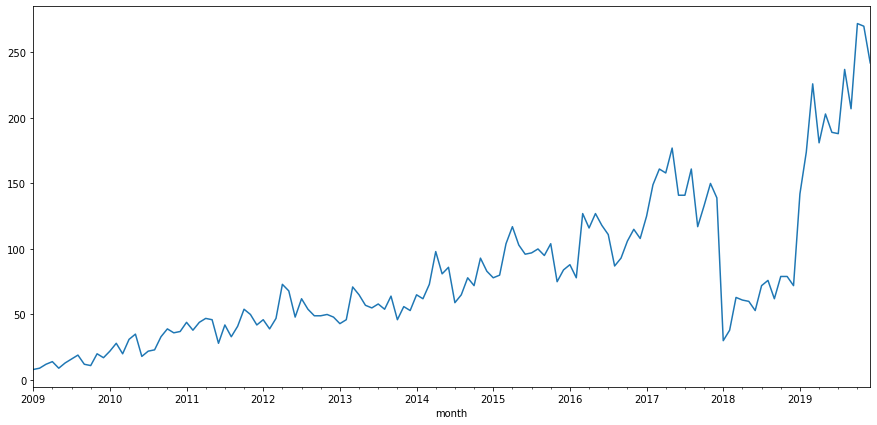

<IPython.core.display.Javascript object>

In [38]:
df["nlp"].plot()

In [45]:
ts = get_ts("nlp")

In [46]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(ts, "additive")
ts_outlierDetection.detector()

In [49]:
outlier_range1 = ts_outlierDetection.outliers[0]
print(f"The outliers range from {outlier_range1[0]} to {outlier_range1[1]}")

The outliers range from 2018-01-01 00:00:00 to 2019-03-01 00:00:00


# Time Series Features

In [42]:
ts

,month,nlp
0,2009-01-01,8
1,2009-02-01,9
2,2009-03-01,12
3,2009-04-01,14
4,2009-05-01,9
...,...,...
127,2019-08-01,237
128,2019-09-01,207
129,2019-10-01,272
130,2019-11-01,270


<IPython.core.display.Javascript object>

In [87]:
from kats.tsfeatures.tsfeatures import TsFeatures

model = TsFeatures()

output_features = model.transform(ts)
output_features

{'length': 102,
 'mean': 7363.598039215686,
 'var': 21300403.436466742,
 'entropy': 0.4016470209185293,
 'lumpiness': 356461671666.824,
 'stability': 20271639.144655902,
 'flat_spots': 1,
 'hurst': 0.13469844338053386,
 'std1st_der': 416.75983560422014,
 'crossing_points': 3,
 'binarize_mean': 0.5098039215686274,
 'unitroot_kpss': 0.280140745072572,
 'heterogeneity': 88.51628426620516,
 'histogram_mode': 631.0,
 'linearity': 0.9717482971514335,
 'trend_strength': 0.9913721304247879,
 'seasonality_strength': 0.2692517678731515,
 'spikiness': 7831766.042654435,
 'peak': 5,
 'trough': 1,
 'level_shift_idx': 42,
 'level_shift_size': 286.59999999999945,
 'y_acf1': 0.9602691049041775,
 'y_acf5': 3.9927630168816193,
 'diff1y_acf1': -0.2542218413075134,
 'diff1y_acf5': 0.14048645075788813,
 'diff2y_acf1': -0.5232180170984803,
 'diff2y_acf5': 0.3145385069028915,
 'y_pacf5': 0.9709406041910852,
 'diff1y_pacf5': 0.18304562350131168,
 'diff2y_pacf5': 0.8481678797612564,
 'seas_acf1': 0.77548623168

<IPython.core.display.Javascript object>